#Milestone Project 1: Food Vision Big

see the annotated version of this notebook on GitHub

In [1]:
!pip install tensorflow==2.8.0
import tensorflow as tf
tf.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

'2.8.0'

In [2]:
# !pip install protobuf==3.20.3

## Check our GPU

* Google colab offers free GPUs (thank you Google), however, not all of them are compatible with mixed precision training.
Google Colab offers:
* K80 (Not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 ( from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus#compute)

In [3]:
#if the following line doesn't output "Tesla T4", you can try getting access to
#another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
#rerunning this cell
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-46305973-a214-ac6e-4980-9d39b27098cb)


##Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
#download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-08 05:39:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-08 05:39:36 (76.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
#Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use tensorflow dataset to download data

If you want to get an overview of TensorFlow Dataset (TFDS), read the guide


In [6]:
#Get TensorFlow Dataset
import tensorflow_datasets as tfds


In [7]:
#list all available datasets
datasets_list = tfds.list_builders() #get all available datasets in TFDS

print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets

True


In [8]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split=["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, #data returned in turple format (data, label)
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5HGYRQ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5HGYRQ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Dataset
To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded?)
* Do the label match up with the calss names?

In [9]:
#Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
#Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
#Take one sample of the train data
train_one_sample = train_data.take(1) # sample are in format (image_tensor, label)

In [12]:
#what does one sample of our training data look like
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
#output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}

  """)


  Image shape: (512, 288, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 93,
  Class name (str form): steak
  
  


In [14]:
#What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 288, 3), dtype=uint8, numpy=
array([[[148, 103,  36],
        [147, 102,  35],
        [147, 102,  35],
        ...,
        [146, 111,  53],
        [146, 111,  53],
        [146, 111,  53]],

       [[147, 102,  35],
        [147, 102,  35],
        [148, 103,  36],
        ...,
        [145, 110,  52],
        [145, 110,  52],
        [145, 110,  52]],

       [[143,  98,  31],
        [144,  99,  32],
        [146, 101,  33],
        ...,
        [146, 111,  55],
        [146, 111,  55],
        [145, 110,  54]],

       ...,

       [[113,  69,  94],
        [113,  69,  94],
        [112,  68,  93],
        ...,
        [ 77,  53,  67],
        [ 76,  52,  66],
        [ 78,  54,  68]],

       [[115,  71,  96],
        [115,  71,  96],
        [114,  70,  95],
        ...,
        [ 79,  55,  69],
        [ 81,  54,  69],
        [ 82,  55,  70]],

       [[116,  72,  97],
        [117,  73,  98],
        [117,  73,  98],
        ...,
        [ 75,  51,  6

In [15]:
import tensorflow as tf
#what are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from tensorFlow Datasets


In [16]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path=PosixGPath('/tmp/tmpfwundkbztfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_exam

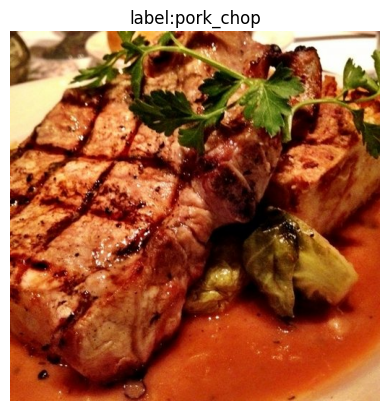

In [17]:
import matplotlib.pyplot as plt


#Plot an image tensor
target_data = train_data.take(1)
plt.figure()
for image, label in target_data:
  plt.imshow(image)
  plt.title(f"label:{class_names[label.numpy()]}") #add title to image to verify the label is associate with the right image
  plt.axis(False)

##Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc)

However, not all data (including data from TensorFlow Datasets) comes like this

So in order to get it ready for a neural network, you 'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `fload16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications, we don't need to rescale our data (these architecture have rescaling built-in)

This means our functions need to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [18]:
#make a function for preprocessing images
def preprocess_img(image, label, image_shape = 224):
  """
  Converts image data type from 'uint8' -> 'float32'
  Reshapes image to (image_shape, image_shape, color_channels)
  """
  image = tf.image.resize(image, [image_shape, image_shape]) #reshape target image
  # image = image/255. #scale image values => not required with EfficientNetBX model from tf.keras.applications
  return tf.cast(image, dtype = tf.float32), label # return (float32_image, label) tuple


In [19]:
#Preprocess a single sample image and check the outputs
preprocessed_image = preprocess_img(image, label)[0]
print(f"image before preprocessing:\n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"image after preprocessing:\n {preprocessed_image[:2]},...., \nShape: {preprocessed_image.shape}, \nDatatype: {preprocessed_image.dtype}\n" )

image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

image after preprocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]],...., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



##Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance


In [20]:
#map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

#Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

#map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

#

In [21]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, Tensorflow, map this preprocessing function(`preprocess_img`) accross our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch"

## Create modelling callback

We're going to create a couple of callbacls to help us while our model trains:
* TensorBoard callback to log training results ( so we can visualize them later if need to be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [22]:
# Create tensorboard callback (inport from helper_function.py)

from helper_functions import create_tensorboard_callback

#create a model checkpoint callback to save our model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only=True,
                                                      verbose = 0)# don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16  data types to speed up model performance

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") #set global data policy to mixed precision

In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model


In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)

base_model =tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name="input_layer")
#note: efficientnetBX models have rescaling built-in but if your model doesn't you can have a layer like below
#x = preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs, training = False) # make sure layers which should be in inference must only stay the same
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)


#compile our model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


16719872/16705208 [==============================] - 0s 0us/step


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

##Checking layer dtype policies (are we using mixed precision?)


In [27]:
#Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable` : is the layer trainable or not (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with  

In [28]:
# Check the dtype_policy attributes of layers in base model
for layer in model.layers[1].layers[:20]: #check the layers of the base model(layer at the index 1 of model)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

##Fit the feature extraction model

if our goal is to fine-tune a pretrained model, the general order of doing thing is:
  1. build a feature extraction model (train a couple output layers with base layers frozen)
  2. Fine-tune some of the frozen layers

In [29]:
#Fit the model
model_101_food_classes_feature_extract = model.fit(train_data,
                                                   epochs = 3,
                                                   steps_per_epoch = len(train_data),
                                                   validation_data = test_data,
                                                   validation_steps = int(0.15*len(test_data)),
                                                   callbacks = [create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230808-055204
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8221 - accuracy: 0.5579

2368/2368 [==============================] - 223s 87ms/step - loss: 1.8221 - accuracy: 0.5579 - val_loss: 1.2215 - val_accuracy: 0.6843
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2927 - accuracy: 0.6669

2368/2368 [==============================] - 200s 83ms/step - loss: 1.2926 - accuracy: 0.6669 - val_loss: 1.1201 - val_accuracy: 0.7015
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1418 - accuracy: 0.7019

2368/2368 [==============================] - 199s 83ms/step - loss: 1.1418 - accuracy: 0.7019 - val_loss: 1.0890 - val_accuracy: 0.7111


In [30]:
#Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 62s 78ms/step - loss: 1.0816 - accuracy: 0.7096


[1.0816161632537842, 0.7095841765403748]

#Off to you...

We've covered alot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper (77,4%)

In other words, you're going to create food vision big